In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Importing Required Libraries

In [2]:
import os
import torch
import torchvision
from torchvision import *
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#Loading Data

In [3]:
data_dir = '/content/drive/My Drive/2750'

print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)

['HerbaceousVegetation', 'AnnualCrop', 'Pasture', 'SeaLake', 'Forest', 'River', 'Residential', 'Industrial', 'PermanentCrop', 'Highway']
['HerbaceousVegetation', 'AnnualCrop', 'Pasture', 'SeaLake', 'Forest', 'River', 'Residential', 'Industrial', 'PermanentCrop', 'Highway']


In [ ]:
data=os.listdir(data_dir+"/AnnualCrop")

In [ ]:
len(data)

3000

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
dataset = ImageFolder(data_dir, transform=transform)

In [ ]:
len(dataset)

27000

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.5843, 0.5765, 0.5725,  ..., 0.4000, 0.4078, 0.4039],
         [0.5843, 0.5843, 0.5843,  ..., 0.4000, 0.4078, 0.4039],
         [0.5608, 0.5647, 0.5765,  ..., 0.4000, 0.4000, 0.4039],
         ...,
         [0.5529, 0.5529, 0.5373,  ..., 0.4039, 0.3922, 0.3961],
         [0.5098, 0.5176, 0.5059,  ..., 0.4118, 0.4118, 0.4196],
         [0.4784, 0.4784, 0.4706,  ..., 0.4157, 0.4157, 0.4196]],

        [[0.4745, 0.4745, 0.4706,  ..., 0.3529, 0.3608, 0.3569],
         [0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
         [0.4588, 0.4510, 0.4549,  ..., 0.3608, 0.3529, 0.3569],
         ...,
         [0.4588, 0.4588, 0.4588,  ..., 0.3647, 0.3529, 0.3529],
         [0.4353, 0.4392, 0.4314,  ..., 0.3686, 0.3647, 0.3725],
         [0.4157, 0.4118, 0.4039,  ..., 0.3725, 0.3725, 0.3725]],

        [[0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
         [0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
         [0.4549, 0.4588, 0.4745,  ..., 0.3961, 0.3922, 0.

In [ ]:
print(dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  AnnualCrop (0)


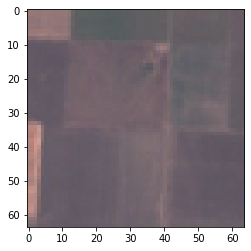

In [ ]:
show_example(*dataset[0])

#Train,Test and Validation Split

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
test_size = 5000
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(22000, 5000)

In [ ]:
val_size = 2000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(25000, 2000)

In [ ]:
batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


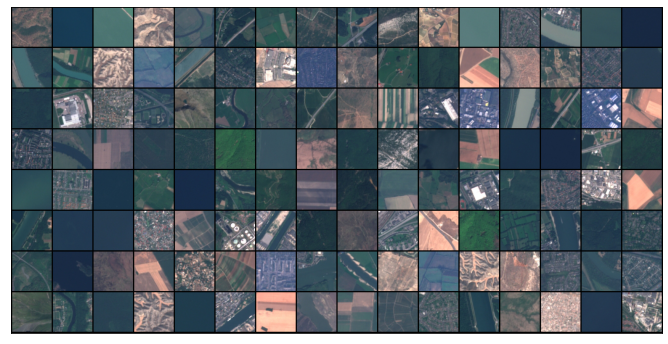

In [ ]:
show_batch(train_dl)

#Model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #32 x 64 x 64
            nn.ReLU(),
            #32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #64 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #128 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            #128 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            #256 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            #256 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            #512 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            #512 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4

            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0339,  0.0219, -0.0073, -0.0076,  0.0084,  0.0239,  0.0235,  0.0163,
         0.0056,  0.0178], grad_fn=<SelectBackward>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.11996694654226303, 'val_loss': 2.3032631874084473}

In [ ]:
num_epochs = 120
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.8497, val_loss: 1.4616, val_acc: 0.3860
Epoch [1], train_loss: 1.1481, val_loss: 0.9843, val_acc: 0.6228
Epoch [2], train_loss: 0.8339, val_loss: 0.8408, val_acc: 0.6807
Epoch [3], train_loss: 0.6946, val_loss: 0.6133, val_acc: 0.7858
Epoch [4], train_loss: 0.5762, val_loss: 0.5062, val_acc: 0.8282
Epoch [5], train_loss: 0.4918, val_loss: 0.4683, val_acc: 0.8397
Epoch [6], train_loss: 0.4677, val_loss: 0.4511, val_acc: 0.8527
Epoch [7], train_loss: 0.3983, val_loss: 0.3579, val_acc: 0.8747
Epoch [8], train_loss: 0.3658, val_loss: 0.3445, val_acc: 0.8869
Epoch [9], train_loss: 0.3291, val_loss: 0.4016, val_acc: 0.8682
Epoch [10], train_loss: 0.2904, val_loss: 0.2920, val_acc: 0.9070
Epoch [11], train_loss: 0.2536, val_loss: 0.3302, val_acc: 0.8878
Epoch [12], train_loss: 0.2470, val_loss: 0.2749, val_acc: 0.9046
Epoch [13], train_loss: 0.2345, val_loss: 0.2207, val_acc: 0.9236
Epoch [14], train_loss: 0.2144, val_loss: 0.2442, val_acc: 0.9197
Epoch [15], train_lo

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.1665, val_loss: 0.2288, val_acc: 0.9327
Epoch [1], train_loss: 0.1512, val_loss: 0.2059, val_acc: 0.9385
Epoch [2], train_loss: 0.1476, val_loss: 0.2003, val_acc: 0.9308
Epoch [3], train_loss: 0.1517, val_loss: 0.2316, val_acc: 0.9312
Epoch [4], train_loss: 0.1342, val_loss: 0.1987, val_acc: 0.9349
Epoch [5], train_loss: 0.1414, val_loss: 0.1882, val_acc: 0.9304
Epoch [6], train_loss: 0.1232, val_loss: 0.2105, val_acc: 0.9358
Epoch [7], train_loss: 0.1221, val_loss: 0.1827, val_acc: 0.9485
Epoch [8], train_loss: 0.1190, val_loss: 0.1667, val_acc: 0.9511
Epoch [9], train_loss: 0.1135, val_loss: 0.1644, val_acc: 0.9488
Epoch [10], train_loss: 0.1260, val_loss: 0.2075, val_acc: 0.9250
Epoch [11], train_loss: 0.1073, val_loss: 0.1631, val_acc: 0.9426
Epoch [12], train_loss: 0.1028, val_loss: 0.2317, val_acc: 0.9297
Epoch [13], train_loss: 0.0916, val_loss: 0.1939, val_acc: 0.9467
Epoch [14], train_loss: 0.0942, val_loss: 0.2370, val_acc: 0.9336
Epoch [15], train_lo

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6588, val_loss: 1.2339, val_acc: 0.4840
Epoch [1], train_loss: 1.0363, val_loss: 0.8491, val_acc: 0.6877
Epoch [2], train_loss: 0.7779, val_loss: 0.6712, val_acc: 0.7553
Epoch [3], train_loss: 0.5963, val_loss: 0.5633, val_acc: 0.7985
Epoch [4], train_loss: 0.5096, val_loss: 0.4932, val_acc: 0.8277
Epoch [5], train_loss: 0.4128, val_loss: 0.3741, val_acc: 0.8685
Epoch [6], train_loss: 0.3554, val_loss: 0.4094, val_acc: 0.8664
Epoch [7], train_loss: 0.3017, val_loss: 0.3411, val_acc: 0.8868
Epoch [8], train_loss: 0.2536, val_loss: 0.2599, val_acc: 0.9156
Epoch [9], train_loss: 0.2325, val_loss: 0.2885, val_acc: 0.9063
Epoch [10], train_loss: 0.2117, val_loss: 0.2230, val_acc: 0.9319
Epoch [11], train_loss: 0.1910, val_loss: 0.2062, val_acc: 0.9334
Epoch [12], train_loss: 0.1845, val_loss: 0.2290, val_acc: 0.9290
Epoch [13], train_loss: 0.1615, val_loss: 0.2709, val_acc: 0.9203
Epoch [14], train_loss: 0.1600, val_loss: 0.1762, val_acc: 0.9404
Epoch [15], train_lo

#Model with Dropout


In [ ]:
class CnnModelWithDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #32 x 64 x 64
            nn.ReLU(),
            #32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #64 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #128 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            #128 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            #256 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            #256 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            #512 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            #512 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4

            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
modelWithDropout = CnnModelWithDropout()
modelWithDropout

CnnModelWithDropout(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), str

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(modelWithDropout, device);

In [ ]:
modelWithDropout = to_device(CnnModelWithDropout(), device)

In [ ]:
history = fit(num_epochs, lr, modelWithDropout, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7341, val_loss: 1.2527, val_acc: 0.4789
Epoch [1], train_loss: 1.0485, val_loss: 0.8701, val_acc: 0.6731
Epoch [2], train_loss: 0.8414, val_loss: 0.7304, val_acc: 0.7379
Epoch [3], train_loss: 0.6536, val_loss: 0.6936, val_acc: 0.7490
Epoch [4], train_loss: 0.5494, val_loss: 0.5245, val_acc: 0.8226
Epoch [5], train_loss: 0.4775, val_loss: 0.4316, val_acc: 0.8474
Epoch [6], train_loss: 0.4200, val_loss: 0.4520, val_acc: 0.8409
Epoch [7], train_loss: 0.3644, val_loss: 0.4460, val_acc: 0.8484
Epoch [8], train_loss: 0.3382, val_loss: 0.3328, val_acc: 0.8917
Epoch [9], train_loss: 0.3208, val_loss: 0.3183, val_acc: 0.8944
Epoch [10], train_loss: 0.2818, val_loss: 0.2666, val_acc: 0.9179
Epoch [11], train_loss: 0.2548, val_loss: 0.2924, val_acc: 0.9037
Epoch [12], train_loss: 0.2446, val_loss: 0.2903, val_acc: 0.9099
Epoch [13], train_loss: 0.2176, val_loss: 0.2896, val_acc: 0.9127
Epoch [14], train_loss: 0.2036, val_loss: 0.2605, val_acc: 0.9081
Epoch [15], train_lo

#Transfer Learning 

In [4]:
 transform=transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [5]:
dataset1 = ImageFolder(data_dir, transform=transform)

In [6]:
val_size = 2000
train_size = len(dataset1) - val_size

train_ds, val_ds = random_split(dataset1, [train_size, val_size])
len(train_ds), len(val_ds)

(25000, 2000)

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64)

##Denset121

In [8]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
import time

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [11]:

epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 2.293.. Test loss: 2.208.. Test accuracy: 0.230
Epoch 1/1.. Train loss: 2.024.. Test loss: 1.853.. Test accuracy: 0.375
Epoch 1/1.. Train loss: 1.623.. Test loss: 1.644.. Test accuracy: 0.419
Epoch 1/1.. Train loss: 1.385.. Test loss: 1.414.. Test accuracy: 0.543
Epoch 1/1.. Train loss: 1.250.. Test loss: 1.343.. Test accuracy: 0.542
Epoch 1/1.. Train loss: 1.146.. Test loss: 1.198.. Test accuracy: 0.606
Epoch 1/1.. Train loss: 1.173.. Test loss: 1.019.. Test accuracy: 0.670
Epoch 1/1.. Train loss: 1.014.. Test loss: 1.003.. Test accuracy: 0.675
Epoch 1/1.. Train loss: 1.070.. Test loss: 0.910.. Test accuracy: 0.710
Epoch 1/1.. Train loss: 0.995.. Test loss: 0.964.. Test accuracy: 0.672
Epoch 1/1.. Train loss: 0.876.. Test loss: 0.898.. Test accuracy: 0.680
Epoch 1/1.. Train loss: 0.994.. Test loss: 0.794.. Test accuracy: 0.741
Epoch 1/1.. Train loss: 0.953.. Test loss: 0.880.. Test accuracy: 0.696
Epoch 1/1.. Train loss: 0.838.. Test loss: 0.826.. Test accuracy

In [12]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.714.. Test loss: 0.608.. Test accuracy: 0.794
Epoch 1/1.. Train loss: 0.667.. Test loss: 0.549.. Test accuracy: 0.810
Epoch 1/1.. Train loss: 0.493.. Test loss: 0.601.. Test accuracy: 0.776
Epoch 1/1.. Train loss: 0.635.. Test loss: 0.571.. Test accuracy: 0.804
Epoch 1/1.. Train loss: 0.737.. Test loss: 0.567.. Test accuracy: 0.802
Epoch 1/1.. Train loss: 0.596.. Test loss: 0.578.. Test accuracy: 0.790
Epoch 1/1.. Train loss: 0.564.. Test loss: 0.562.. Test accuracy: 0.805
Epoch 1/1.. Train loss: 0.557.. Test loss: 0.563.. Test accuracy: 0.798
Epoch 1/1.. Train loss: 0.604.. Test loss: 0.554.. Test accuracy: 0.811
Epoch 1/1.. Train loss: 0.671.. Test loss: 0.525.. Test accuracy: 0.813
Epoch 1/1.. Train loss: 0.614.. Test loss: 0.581.. Test accuracy: 0.798
Epoch 1/1.. Train loss: 0.667.. Test loss: 0.595.. Test accuracy: 0.787
Epoch 1/1.. Train loss: 0.712.. Test loss: 0.550.. Test accuracy: 0.811
Epoch 1/1.. Train loss: 0.593.. Test loss: 0.540.. Test accuracy

##Resnet50

In [ ]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.280.. Test loss: 0.256.. Test accuracy: 0.922
Epoch 1/1.. Train loss: 0.336.. Test loss: 0.278.. Test accuracy: 0.912
Epoch 1/1.. Train loss: 0.255.. Test loss: 0.280.. Test accuracy: 0.903
Epoch 1/1.. Train loss: 0.383.. Test loss: 0.277.. Test accuracy: 0.909
Epoch 1/1.. Train loss: 0.376.. Test loss: 0.303.. Test accuracy: 0.906
Epoch 1/1.. Train loss: 0.356.. Test loss: 0.281.. Test accuracy: 0.904
Epoch 1/1.. Train loss: 0.220.. Test loss: 0.258.. Test accuracy: 0.918
Epoch 1/1.. Train loss: 0.270.. Test loss: 0.260.. Test accuracy: 0.918
Epoch 1/1.. Train loss: 0.259.. Test loss: 0.262.. Test accuracy: 0.916
Epoch 1/1.. Train loss: 0.228.. Test loss: 0.245.. Test accuracy: 0.929
Epoch 1/1.. Train loss: 0.211.. Test loss: 0.264.. Test accuracy: 0.918
Epoch 1/1.. Train loss: 0.249.. Test loss: 0.243.. Test accuracy: 0.923
Epoch 1/1.. Train loss: 0.293.. Test loss: 0.253.. Test accuracy: 0.917
Epoch 1/1.. Train loss: 0.308.. Test loss: 0.248.. Test accuracy

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.205.. Test loss: 0.170.. Test accuracy: 0.942
Epoch 1/1.. Train loss: 0.232.. Test loss: 0.198.. Test accuracy: 0.931
Epoch 1/1.. Train loss: 0.202.. Test loss: 0.197.. Test accuracy: 0.935
Epoch 1/1.. Train loss: 0.169.. Test loss: 0.208.. Test accuracy: 0.932
Epoch 1/1.. Train loss: 0.250.. Test loss: 0.191.. Test accuracy: 0.934
Epoch 1/1.. Train loss: 0.248.. Test loss: 0.187.. Test accuracy: 0.935
Epoch 1/1.. Train loss: 0.117.. Test loss: 0.187.. Test accuracy: 0.939
Epoch 1/1.. Train loss: 0.172.. Test loss: 0.208.. Test accuracy: 0.925
Epoch 1/1.. Train loss: 0.240.. Test loss: 0.204.. Test accuracy: 0.935
Epoch 1/1.. Train loss: 0.207.. Test loss: 0.190.. Test accuracy: 0.937
Epoch 1/1.. Train loss: 0.275.. Test loss: 0.199.. Test accuracy: 0.924
Epoch 1/1.. Train loss: 0.256.. Test loss: 0.205.. Test accuracy: 0.931
Epoch 1/1.. Train loss: 0.269.. Test loss: 0.206.. Test accuracy: 0.925
Epoch 1/1.. Train loss: 0.222.. Test loss: 0.181.. Test accuracy

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.208.. Test loss: 0.179.. Test accuracy: 0.938
Epoch 1/1.. Train loss: 0.190.. Test loss: 0.177.. Test accuracy: 0.943
Epoch 1/1.. Train loss: 0.161.. Test loss: 0.178.. Test accuracy: 0.938
Epoch 1/1.. Train loss: 0.183.. Test loss: 0.181.. Test accuracy: 0.938
Epoch 1/1.. Train loss: 0.190.. Test loss: 0.194.. Test accuracy: 0.937
Epoch 1/1.. Train loss: 0.234.. Test loss: 0.164.. Test accuracy: 0.940
Epoch 1/1.. Train loss: 0.207.. Test loss: 0.156.. Test accuracy: 0.944
Epoch 1/1.. Train loss: 0.233.. Test loss: 0.172.. Test accuracy: 0.944
Epoch 1/1.. Train loss: 0.230.. Test loss: 0.192.. Test accuracy: 0.937
Epoch 1/1.. Train loss: 0.199.. Test loss: 0.182.. Test accuracy: 0.942
Epoch 1/1.. Train loss: 0.164.. Test loss: 0.155.. Test accuracy: 0.951
Epoch 1/1.. Train loss: 0.185.. Test loss: 0.181.. Test accuracy: 0.938
Epoch 1/1.. Train loss: 0.184.. Test loss: 0.158.. Test accuracy: 0.944
Epoch 1/1.. Train loss: 0.219.. Test loss: 0.169.. Test accuracy

##VGG-19


In [8]:
model=models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(in_features=4096,out_features=10),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 21.090.. Test loss: 2.252.. Test accuracy: 0.228
Epoch 1/1.. Train loss: 2.009.. Test loss: 1.531.. Test accuracy: 0.522
Epoch 1/1.. Train loss: 1.797.. Test loss: 1.210.. Test accuracy: 0.597
Epoch 1/1.. Train loss: 1.590.. Test loss: 1.174.. Test accuracy: 0.586
Epoch 1/1.. Train loss: 1.493.. Test loss: 1.205.. Test accuracy: 0.603
Epoch 1/1.. Train loss: 1.504.. Test loss: 1.182.. Test accuracy: 0.619
Epoch 1/1.. Train loss: 1.722.. Test loss: 1.041.. Test accuracy: 0.648
Epoch 1/1.. Train loss: 1.524.. Test loss: 1.101.. Test accuracy: 0.674
Epoch 1/1.. Train loss: 1.325.. Test loss: 1.065.. Test accuracy: 0.625
Epoch 1/1.. Train loss: 1.326.. Test loss: 0.979.. Test accuracy: 0.677
Epoch 1/1.. Train loss: 1.390.. Test loss: 0.910.. Test accuracy: 0.700
Epoch 1/1.. Train loss: 1.335.. Test loss: 1.023.. Test accuracy: 0.665
Epoch 1/1.. Train loss: 1.306.. Test loss: 1.179.. Test accuracy: 0.618
Epoch 1/1.. Train loss: 1.412.. Test loss: 1.024.. Test accurac

##GoogleNet

In [8]:
model=models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [9]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
epochs = 2
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_dl):.3f}")
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 2.336.. Test loss: 2.344.. Test accuracy: 0.065
Epoch 1/2.. Train loss: 2.340.. Test loss: 2.296.. Test accuracy: 0.112
Epoch 1/2.. Train loss: 2.255.. Test loss: 2.242.. Test accuracy: 0.187
Epoch 1/2.. Train loss: 2.222.. Test loss: 2.182.. Test accuracy: 0.281
Epoch 1/2.. Train loss: 2.128.. Test loss: 2.117.. Test accuracy: 0.375
Epoch 1/2.. Train loss: 2.092.. Test loss: 2.037.. Test accuracy: 0.445
Epoch 1/2.. Train loss: 1.964.. Test loss: 1.954.. Test accuracy: 0.498
Epoch 1/2.. Train loss: 1.909.. Test loss: 1.888.. Test accuracy: 0.480
Epoch 1/2.. Train loss: 1.875.. Test loss: 1.845.. Test accuracy: 0.464
Epoch 1/2.. Train loss: 1.855.. Test loss: 1.760.. Test accuracy: 0.534
Epoch 1/2.. Train loss: 1.736.. Test loss: 1.696.. Test accuracy: 0.563
Epoch 1/2.. Train loss: 1.702.. Test loss: 1.676.. Test accuracy: 0.557
Epoch 1/2.. Train loss: 1.649.. Test loss: 1.575.. Test accuracy: 0.605
Epoch 1/2.. Train loss: 1.615.. Test loss: 1.522.. Test accuracy